## qflib Library Examples

In [1]:
import qflib as qf
import numpy as np
import os
import matplotlib.pyplot as plt


print("qflib version: {0}".format(qf.version()))
print("pid: {0}".format(os.getpid()))

qflib version: 0.3.1-debug
pid: 34479


In [2]:
name = "World"
print(qf.sayHello(name))

Hello World!


In [ ]:
x &= [1, 2, 3]
y = [4, 5]
op = qf.outerProd(x, y)
print(f'x: {x}\ny: {y}')
print(f'outerProd:\n{op}')

x: [1, 2, 3]
y: [4, 5]
outerProd:
[[ 4.  5.]
 [ 8. 10.]
 [12. 15.]]


### Analytic Prices

In [4]:
#fwdprice
fwdpx = qf.fwdPrice(spot = 100, timetoexp = 1.0, intrate = 0.02, divyield = 0.04)
print('Forward price analytic solution')
print(f'Price={fwdpx:.4f}')

Forward price analytic solution
Price=98.0199


In [5]:
#digibs
digi = qf.digiBS(payofftype = 1, spot = 100, timetoexp = 1.0, striKe = 100,
                  intrate = 0.02, divyield = 0.04, volatility = 0.2)
print('Digital option using BlacK-Scholes analytic solution')
print(f'Price={digi:.4f}')

Digital option using Black-Scholes analytic solution
Price=0.4124


In [6]:
euro = qf.euroBS(payofftype = 1, spot = 100, timetoexp = 1.0, strike = 100,
                  intrate = 0.02, divyield = 0.04, volatility = 0.4)
print('European option using Black-Scholes analytic solution')
print(f'Price={euro:.4f}')

European option using Black-Scholes analytic solution
Price=14.4327


# Knockout Forward

## Pricing



$$
\begin{equation*}
\begin{aligned}
&V(T) = (S_T - K) \mathbf{1}_{\{ S_T \geq H \}} (S_T - K) \Theta(S_{T1} - H)\\

\\

&V(t) = \mathbb{E}_t [(S_T - K) \Theta(S_{T1} - H)] e^{-r(T-t)}\\



&\quad \quad = \mathbb{E}_t [\mathbb{E}_{T1} [(S_T - K)] \Theta(S_{T_1} - H)] e^{-r(T-t)}\\



&\quad \quad = \mathbb{E}_t [ (e^{(r-q)(T-T_1)}S_{T_1} - K) \Theta(S_{T1} - H) ] e^{-r(T-t)}\\



&\quad \quad = \mathbb{E}_t [ e^{(r-q)(T-T_1)} S_{T1} \Theta(S_{T1} - H) - K \Theta(S_{T1} - H) ] e^{-r(T-t)}\\



&\quad \quad =  e^{-r(T-t)} \{ [ e^{(r-q)(T-T_1)} \mathbb{E}_t [ (S_{T_1} - H) \Theta(S_{T1} - H) ]\\
&\quad \quad \quad \quad  + H \mathbb{E}_t [ \Theta(S_{T1} - H) ] ]- K \mathbb{E}_t [ \Theta(S_{T1} - H) ] \}\\



&\quad \quad = e^{-r(T-t)} \{ [ e^{(r-q)(T-T_1)} \mathbb{E}_t [( S_{T_1} - H) \Theta(S_{T1} - H) ] + e^{(r-q)(T-T_1)} \mathbb{E}_t [ H \Theta(S_{T1} - H) ] ]\\
&\quad \quad \quad \quad  - K \mathbb{E}_t [ \Theta(S_{T1} - H) ] \}\\


&\quad \quad = e^{(r-q)(T-T_1)} e^{-r(T-T_1)} e^{-r(T1-t)}\mathbb{E}_t [ (S_{T_1}-H)^+ ]\\



&\quad \quad \quad \quad + e^{-r(T-T_1)} e^{-r(T1-t)} (e^{(r-q)(T-T_1)}H - K) \mathbb{E}_t [ \Theta(S_{T1} - H) ]\\



&\quad \quad = e^{-q(T-T_1)} C(S_t, T_1, H) + e^{-r(T-T_1)} \left( (e^{(r-q)(T-T_1)}H - K) \right) DOP(St,T_1, H)\\
\end{aligned}
\end{equation*}
$$


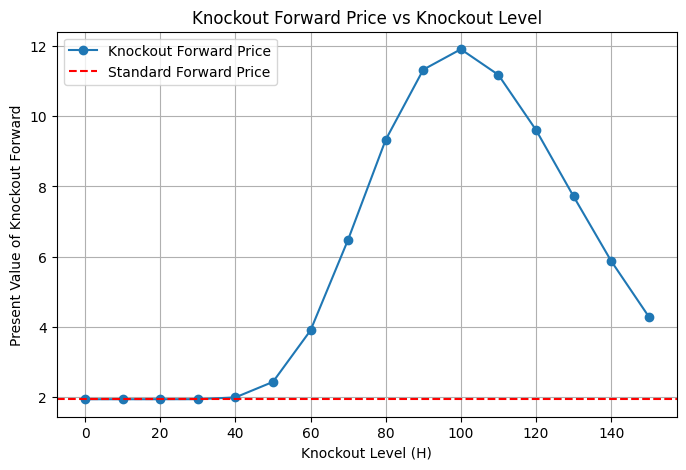

In [ ]:
spot = 100
strike = 100
intrate = 0.04
divyield = 0.02
volatility = 0.4
timetoexp = 1.0
timetoKO = 0.5

H_values = np.arange(0, 151, 10)
ko_forward_prices = []

for h in H_values:
    price = qf.koFwd(spot=spot, strike=strike, KOlevel=h, timetoexp=timetoexp, 
                      timetoKO=timetoKO, intrate=intrate, divyield=divyield, volatility=volatility)
    ko_forward_prices.append(price)

pv_fwd = np.exp(-intrate*(timetoexp))*(spot*np.exp((intrate - divyield)*timetoexp) - strike)
plt.figure(figsize=(8, 5))
plt.plot(H_values, ko_forward_prices, marker='o', label='Knockout Forward Price')
plt.axhline(y=pv_fwd, color='r', linestyle='--', label='Standard Forward Price')
plt.xlabel('Knockout Level (H)')
plt.ylabel('Present Value of Knockout Forward')
plt.title('Knockout Forward Price vs Knockout Level')
plt.legend()
plt.grid()
plt.show()


# Capped Forward



$$
V(T) = \min(K_2, S_T - K_1)
$$

$$
= K_2 - (K_2 - S_T + K_1)^+
$$

$$
= K_2 - (K_1 + K_2 - S_T)^+ \quad \rightarrow \text{put option}
$$

$$
V(t) = \mathbb{E}_t \left[ e^{-r(T-t)} \left( K_2 - e^{-r(T-t)} (K_1 + K_2 - S_T)^+ \right) \right]
$$

$$
V(t) = e^{-r(T-t)} K_2 - e^{-r(T-t)} \mathbb{E}_t \left[ (K_1 + K_2 - S_T)^+ \right]
$$

$$
= e^{-r(T-t)} K_2 - P(K_1 + K_2, T)
$$

where $ P(K_1 + K_2, T) $ represents the price of a put option with strike $ K_1 + K_2 $ and maturity $ T $.


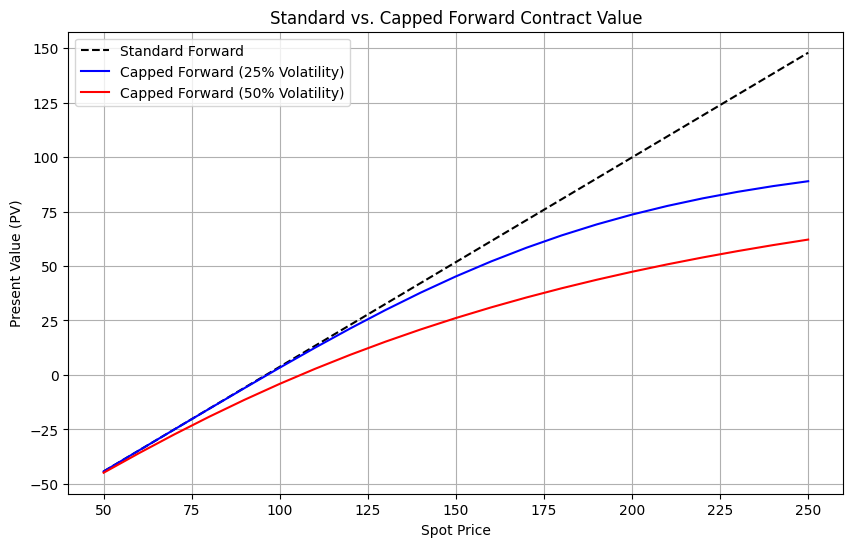

In [19]:
spot_prices = np.arange(50, 260, 10) 
T = 2 
K1 = 100
K2 = 110
r = 0.04
q = 0.02
sigma1 = 0.25
sigma2 = 0.50

fwd_prices = np.array([qf.fwdPrice(S, T, r, q) for S in spot_prices])

capped_fwd_pv_25 = np.array([
    np.exp(-r * T)*K2 - qf.euroBS(-1, S, K1+K2, T, r, q, sigma1)
    for S in spot_prices
])

capped_fwd_pv_50 = np.array([
    np.exp(-r * T)*K2 - qf.euroBS(-1, S, K1+K2, T, r, q, sigma2)
    for S in spot_prices
])

pv_fwd = np.exp(-r*(T))*(spot_prices*np.exp((r - q)*T) - K1)

plt.figure(figsize=(10, 6))
plt.plot(spot_prices, pv_fwd, label='Standard Forward', linestyle='dashed', color='black')
plt.plot(spot_prices, capped_fwd_pv_25, label='Capped Forward (25% Volatility)', color='blue')
plt.plot(spot_prices, capped_fwd_pv_50, label='Capped Forward (50% Volatility)', color='red')

plt.xlabel("Spot Price")
plt.ylabel("Present Value (PV)")
plt.title("Standard vs. Capped Forward Contract Value")
plt.legend()
plt.grid()
plt.show()


Note: Did not use "price the standard forward contact with strike K1 using the function qf.fwdPrice" as indicated in the instruction since we already know K1. 

Used the forward present value formula $V(t) = e^{-r(T-t)}(S_te^{(r-q)(T-t)} -K)$

The economical implication of the capped forward with 25% volatility being of a higher value than the capped forward with 50% volatility is built in the value of the capped forward.
$$V(t) = e^{-r(T-t)} - P(K1+K2, T) $$
Where we decomposed the capped forward value to a constant payoff subtract the price of a put option.

The option price would go up with higher volatility, since there are higher chances for the option to expire in the money. Therefore the option with 50% volatility would be of a higher price than the option with 25% volatility. As a result, the higher volatility, the less value the capped forward would hold. 

Another way of approaching this question is by thinking of the term structure of the capped forward. Holding all else the same, when volatility increases, there are higher chances for the cap to be reached - losing out on the opportunity to make money above the cap level by holding a normal forward.